# Power spectra of mock cluster observations

## Last edited by Charles Romero 22 August 2025

Now that we've considered power spectra in an image which is described by some power spectrum, let's consider the actual kind of image (but idealized, of course) that we might encounter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gcfluct.gc.selfsimilar_gc as ssgc
import gcfluct.spectra.spectra2d as spectra
import gcfluct.spectra.gc_spec_deproj as deproj
import gcfluct.utils.image_filtering as imf
import gcfluct.utils.mock_obs as mo
import astropy.units as u

### Pick a cluster

Defined by self-similar criteria, i.e. solely z and $M_{500}$.

In [2]:
z = 0.4
m500 = 5e14 * u.M_sun 

In [3]:
gc_model = ssgc.SS_Model(z,m500)

In [4]:
#d_ang = ssgc.get_d_ang(z).to("kpc").value
kpc_per_arcsecond = gc_model.d_ang.to("kpc").value / (3600 * 180 / np.pi)
print("kpc per arcsecond: ",kpc_per_arcsecond)

kpc per arcsecond:  5.37273628890832


In [5]:
gc_model.set_xr_USBP()

## Prepare to make a mock cluster image.

We have a radial surface brightness profile in hand, but now we want to add fluctuations to that surface brightness image. To do that, we'll want to make a map with a given power spectrum. In particular, let's choose a plausible (idealized, as always) power spectrum for density (well, emissivity) fluctuations.

In [6]:
# Define a turbulent (3D) power spectrum. 
# I'm ignoring a dissipative scale; the default will put it at very small scales
# I'll also leave the eta_c and eta_d parameters as their defaults.

kc = 1.0e-3         # Assume this is in [pixsize]^(-1) -- so kpc^-1 in our case.
slope = -3        # Power goes as k**slope
p0 = 8e-3         # Arbitrary units at the moment
no_warn = True    # Ignore some warnings (in regards to pixels for image creation) for now.
ps2img = spectra.ImagesFromPS(slope=slope,kc=kc,p0=p0,no_warn=no_warn)

### Let's embark on making images
1. We'll want to define some basic image properties (size, pixel size, etc.)

Let's mimic an XMM image. 

ESAS typically generates images with 2.5 arcecond pixels (for EPIC cameras).
For a specific cluster, or rather, a specific redshift, we can consider the pixel size
either in arcseconds or in kilparsecs. Given that we've defined our power spectrum in
(inverse) kpc, __we need to specify the pixsize in kpc__.

#### A note on field of view (FOV):
XMM's EPIC cameras have a ~30' FOV. So the images go out to 15' radially.
We could try to replicate that in earnest, but we could also trim the image down to 2*R500, radially.

In [7]:
pix_arcsec = 2.5 # 
pixsize = pix_arcsec*kpc_per_arcsecond    # in kpc
# We set no_warn earlier because the class strongly prefers units to be set.
# It's still "optional" insofar as there are use cases where you don't need to set
# the units
pixunits = u.kpc 
n_r500 = 2
npix = int(np.round(gc_model.arcminutes500*2*n_r500*60/pix_arcsec))   
ps2img.set_image_size(npix,pixsize,pixunits=pixunits)
# Same number as in x -- keep things simple.

#### Continuing on making images:

2. Let's generate an image with the input power spectrum and
3. Feed that into gc_model, which will enable it to generate a model image for the cluster.

In [8]:
image = ps2img.generate_realization()
gc_model.set_ss_maps(imagefromps=ps2img) # Let gc_model know the grid used for producing maps.

In [9]:
print(image.max())

25.939131579663805


You might wonder how I've gone from a 3D power spectrum to a 2D image of it.
Well, I haven't -- yet.

4. (Approximately) project the 3D power spectrum image to its 2D counterpart.

We'll do the approximate way to projecting below.

In [10]:
image_is_sz = True # We are modeling (simulating) an X-ray image, not SZ here.
gc_deproj = deproj.SpecDeproj(gc_model,spec_model=ps2img,sz = image_is_sz) 
n_map = gc_deproj.return_integ_nmap(use_obs_spec=False) # Gives factors to translate between P_2D and P_3D

In [11]:
dy_y = np.sqrt(n_map) * image     # Normalized residual.
dy = dy_y * gc_model.y_map      # Residual image in cnts/s/arcmin**2
y_cluster = dy + gc_model.y_map # Image in cnts/s/arcmin**2

In [12]:
y_noise = 1e-6

In [13]:
rng = np.random.default_rng()
noise_realization = rng.normal(loc=0, scale=y_noise, size=y_cluster.shape)
synthetic_image = noise_realization + y_cluster

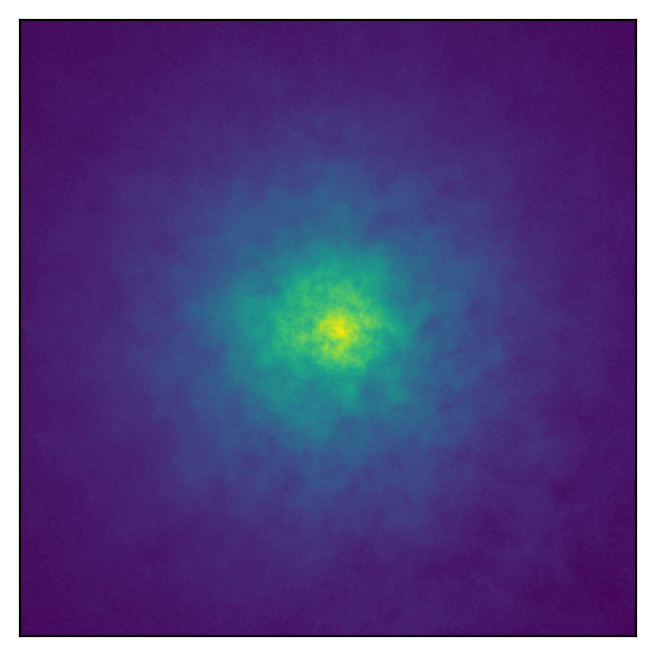

In [14]:
CntFig = plt.figure(1,figsize=(4,4),dpi=200)
CntAx = CntFig.add_subplot(111)
CntAx.imshow(synthetic_image)    
CntAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

Now that I have a toy mock observation, let's consider some different approaches to calculating the fluctuations.

Fundamentally, the fluctuations should live in $\delta y / y$ space, but noise can be scary. So we'll consider taking power spectra on the following images:
1. $\delta y / y$, the straight-forward method.
2. $\delta y / \bar{y}$, the fluctuation map $\delta y$ divided by the area-averaged $y$.
   * We need to determine the region to be examined for this.
4. $H(\delta y / y)$, use some kind of window (we can take it as a Hann window).
   * The window also depends on the region to be examined.
  
Let's consider that we want to calculate the the fluctuations within $R_{500}$.

In [15]:
r500_mask = np.ones(ps2img.rmat.shape)
omit = (ps2img.rmat > gc_model.r500.value)  # r500 will is in kpc already.
r500_mask[omit] = 0

In [16]:
dy_obs = synthetic_image - gc_model.y_map
dy_y_obs = dy_obs / gc_model.y_map  # This is our first option.
dy_y_obj = spectra.PSfromImages(dy_y_obs, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = r500_mask)
dy_y_noise = noise_realization / gc_model.y_map  # Observationally, you won't have access to the *same* noise realization.
noise_dy_y = spectra.PSfromImages(dy_y_noise, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = r500_mask)

In [17]:
y_inc_avg = np.sum(gc_model.y_map * r500_mask) / np.sum(r500_mask)
y_avg = np.sqrt( np.sum( (gc_model.y_map * r500_mask)**2 ) / np.sum(r500_mask) )
print(y_avg, y_inc_avg)
dy_y_avg = spectra.PSfromImages(dy_obs / y_avg, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = r500_mask)
noise_y_avg = spectra.PSfromImages(noise_realization / y_avg, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = r500_mask)

7.291725392458745e-06 7.134861561624763e-06


In [18]:
hann = (np.cos(ps2img.rmat*np.pi / (2*gc_model.r500.value) ))**2
hann_within_r500 = hann[ps2img.rmat <= gc_model.r500.value]
hann_mean = np.mean(hann_within_r500)
hann2_mean = np.sqrt( np.mean(hann_within_r500**2) )
print(hann_mean, hann2_mean, np.max(hann_within_r500), np.min(hann_within_r500) )
hann /= hann2_mean

0.29403524165229056 0.41114674539924145 0.9991902004248993 1.7141066251621265e-07


In [19]:
hann_dy_y = dy_y_obs * hann * r500_mask
dy_y_hann = spectra.PSfromImages(hann_dy_y, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = r500_mask)
hann_noise = noise_realization * hann * r500_mask / gc_model.y_map
noise_hann = spectra.PSfromImages(hann_noise, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = r500_mask)

In [20]:
annuli = [0, gc_model.r500.value]  # Will take an annulus (circle) with 0 <= r < R500.
dy_y_obj.set_annular_mask_by_bin(annuli)
dy_y_avg.set_annular_mask_by_bin(annuli)
dy_y_hann.set_annular_mask_by_bin(annuli)
noise_dy_y.set_annular_mask_by_bin(annuli)
noise_y_avg.set_annular_mask_by_bin(annuli)
noise_hann.set_annular_mask_by_bin(annuli)

In [21]:
dy_y_obj.set_wave_numbers()  # Omit option inputs -> use defaults
noise_dy_y.set_wave_numbers()
dy_y_avg.set_wave_numbers()  # Omit option inputs -> use defaults
noise_y_avg.set_wave_numbers()
dy_y_hann.set_wave_numbers()  # Omit option inputs -> use defaults
noise_hann.set_wave_numbers()

In [22]:
dy_y_obj.ps_via_a12_2d()  # Omit option inputs -> use defaults
noise_dy_y.ps_via_a12_2d()
dy_y_avg.ps_via_a12_2d()  # Omit option inputs -> use defaults
noise_y_avg.ps_via_a12_2d()
dy_y_hann.ps_via_a12_2d()  # Omit option inputs -> use defaults
noise_hann.ps_via_a12_2d()

In [23]:
# Quick way to go over realizations

nReals = 100
for i in range(nReals):
    
    noise_realization2 = rng.normal(loc=0, scale=y_noise, size=y_cluster.shape)
    noise_dy_y.update_img(noise_realization2 / gc_model.y_map)
    noise_y_avg.update_img(noise_realization2 / y_avg)
    noise_hann.update_img(noise_realization2 * hann * r500_mask / gc_model.y_map)
    noise_dy_y.ps_via_a12_2d()
    noise_y_avg.ps_via_a12_2d()
    noise_hann.ps_via_a12_2d()

    if i == 0:
        pk_dy_y = noise_dy_y.a12_pk
        pk_y_avg = noise_y_avg.a12_pk
        pk_hann = noise_hann.a12_pk
    else:
        pk_dy_y = np.hstack([pk_dy_y, noise_dy_y.a12_pk])
        pk_y_avg = np.hstack([pk_y_avg, noise_y_avg.a12_pk])
        pk_hann = np.hstack([pk_hann, noise_hann.a12_pk])


In [24]:
pk_dy_y_rms = np.std(pk_dy_y, axis=1)
pk_y_avg_rms = np.std(pk_y_avg, axis=1)
pk_hann_rms = np.std(pk_hann, axis=1)

pk_dy_y_mean = np.mean(pk_dy_y, axis=1)
pk_y_avg_mean = np.mean(pk_y_avg, axis=1)
pk_hann_mean = np.mean(pk_hann, axis=1)

In [25]:
def plot_amp_spec(img2ps1, ymean, yrms, ax, label=None, prnt = False, offsets=True):

    for ri,a12_pk1 in enumerate(img2ps1.a12_pk.T):
        if prnt:
            print(a12_pk1)
            print("==========================================================")
        amp_spec = np.sqrt( (a12_pk1 - ymean) * 2 * np.pi * img2ps1.a12_kn**2)
        amp_unc = np.sqrt( yrms * 2 * np.pi * img2ps1.a12_kn**2) / 2
        binstr = "; bin {:d}".format(ri+1)
        if offsets:
            myoff = rng.normal(loc=1,scale=0.03)
        else:
            myoff = 1.0
        ax.errorbar(myoff*img2ps1.a12_kn, amp_spec, yerr=amp_unc, label=label+binstr)

[1425.28773194  954.02289523  350.33769773   45.97108126    7.92471843
    4.09679646]
[1511.28806263 1017.48610295  291.40883905   41.25273056    6.9150455
    3.40720332]
[ 974.62608399 1111.61845418  621.18897699   66.44346053   12.04289774
    6.70380942]


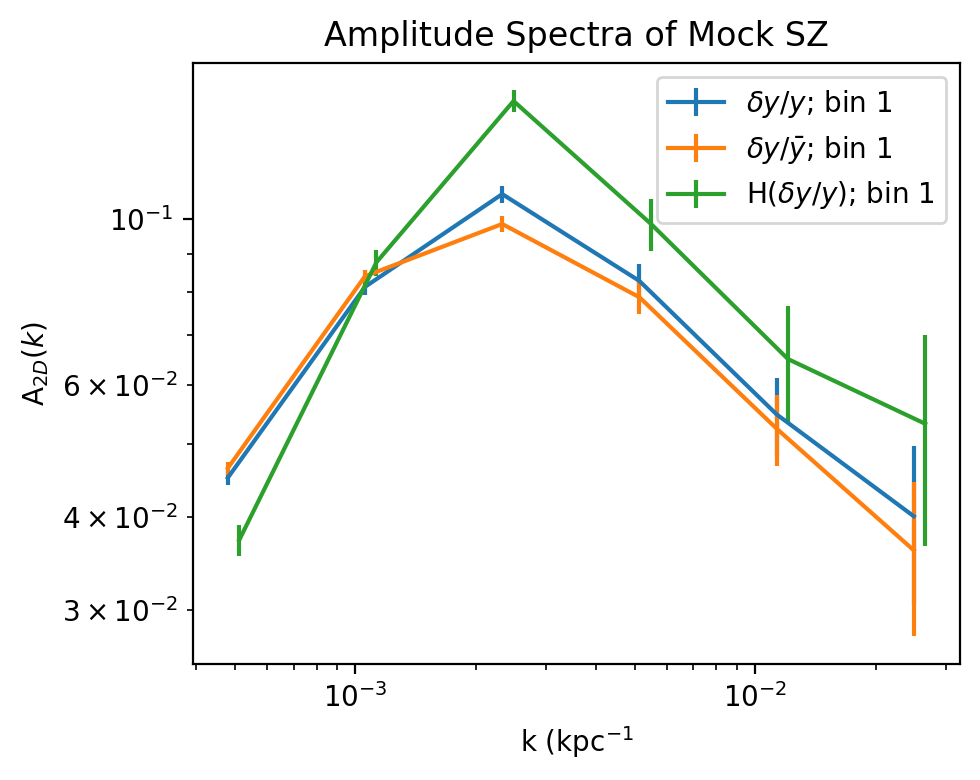

In [26]:
myfig = plt.figure(2,figsize=(5,4),dpi=200)
myfig.clf()
myax = myfig.add_subplot(111)

plot_amp_spec(dy_y_obj, pk_dy_y_mean, pk_dy_y_rms, myax, label = r'$\delta y / y$', prnt=True)
plot_amp_spec(dy_y_avg, pk_y_avg_mean, pk_y_avg_rms, myax, label = r'$\delta y / \bar{y}$', prnt=True)
plot_amp_spec(dy_y_hann, pk_hann_mean, pk_hann_rms, myax, label = r'H($\delta y / y$)', prnt=True)

myax.set_xlabel(r"k (kpc$^{-1}$")
myax.set_ylabel(r"A$_{2D}(k)$")
myax.legend()
myax.set_xscale("log")
myax.set_yscale("log")
myax.set_title("Amplitude Spectra of Mock SZ")
myfig.tight_layout()
outdir = "/home/data/Synthetic/gcfluct/Testing_August/"
myfig.savefig(outdir+"AmplitudeSpectra_ThreeWays_1e-6_3methods.png")